# Skin Detection in Face Images

## Importing Libraries

In [1]:
import imageio as io
import numpy as np
from skimage import morphology
from matplotlib import pyplot as plt
import zipfile
import os
import shutil
import pandas as pd
import urllib.request
from scipy.fft import fftn, ifftn, fftshift

## Downloading the dataset

In [2]:
# Downloading the dataset:
def download_celeba():
    # If using Linux, use this command:
    # !mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

    # Use the lines below if using Windows:
    # import urllib.request
    # url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip'
    # filename = 'celeba.zip'
    # urllib.request.urlretrieve(url, filename)

    # Extract the images that were downloaded in the zip file:
    with zipfile.ZipFile("celeba.zip", "r") as zip_ref:
        zip_ref.extractall("data_faces/") 

def read_celeba():
    root = 'data_faces/img_align_celeba'
    img_list = os.listdir(root)
    print("There are", len(img_list), "images on this database.")

    # Loads the downloaded csv mentioned in Kaggle link on input images section.
    df = pd.read_csv("list_attr_celeba.csv")
    return img_list, df

## Creating dataframe

In [3]:
def create_dataframe_attribute():
    # Creates a data frame with the following attribute, in case it is needed
    # people_smiling = df[['image_id', 'Smiling']]
    # people_smilin

    # Before running this cell, remember to create the folders or check if they already exist.
    # This cell will insert 1000 photos of people smiling on smile folder and 1000 photos of people not smiling on no_smile folder
    # Just change attribute Smiling for any of your choice.
    os.mkdir('data')
    os.mkdir('data/smile')
    os.mkdir('data/no_smile')
    maxNum = 999
    smileFlag, noSmileFlag = 0, 0

    for i, (_, i_row) in enumerate(df.iterrows()):
        if smileFlag < maxNum:
            if i_row['Smiling'] == 1:
                smileFlag += 1
                shutil.copyfile('data_faces/img_align_celeba/' + i_row['image_id'], 'data/smile/' + i_row['image_id'])
        if noSmileFlag < maxNum:
            if i_row['Smiling'] == -1:
                noSmileFlag += 1
                shutil.copyfile('data_faces/img_align_celeba/' + i_row['image_id'], 'data/no_smile/' + i_row['image_id'])
                
    img_list_smile = os.listdir('data/smile')
    img_list_no_smile = os.listdir('data/no_smile')
    
    return img_list_smile, img_list_no_smile

## Lower and upper boundaries

In [4]:
# Lower and upper boundaries for pixel intensities to be considered skin
def lower_upper_boundaries():
    lower = np.array([0, 48, 80], dtype=np.uint8)
    upper = np.array([20, 255, 255], dtype=np.uint8)
    return lower, upper

## RGB to HSV

In [5]:
def rgb_pixel2hsv(rgb_pixel: np.ndarray):
    r,g,b = rgb_pixel/255.0
    hsv_pixel = np.zeros((3,), dtype=np.float64)
    
    cmax = float(max(r, g, b))
    cmin = float(min(r, g, b))
    diff = cmax - cmin
    
    if (cmax == cmin):
        hsv_pixel[0] = 0
    elif (cmax == r):
        hsv_pixel[0] = ((60 * ((g - b) / diff) + 360) % 360)/360.0 * 255
    elif (cmax == g):
        hsv_pixel[0] = ((60 * ((b - r) / diff) + 120) % 360)/360.0 * 255
    elif (cmax == b):
        hsv_pixel[0] = ((60 * ((r - g) / diff) + 240) % 360)/360.0 * 255    
    
    if (cmax == 0):
        hsv_pixel[1] = 0
    else:
        hsv_pixel[1] = (diff / cmax) * 255
        
    hsv_pixel[2] = cmax * 255
        
    return hsv_pixel

def rgb2hsv(input_image: np.ndarray):
    n, m, _ = input_image.shape
    
    output_image = np.array([rgb_pixel2hsv(input_image[i][j]) for i in range(n) for j in range(m)],
                           dtype=np.float64).reshape(n,m,3)
    return output_image

## Creating mask using the color boundaries

In [6]:
def skin_mask(hsv_image: np.ndarray, lower, upper):
    n,m, _ = hsv_image.shape
    auxiliar = np.clip(np.multiply(np.where(hsv_image > lower,255, 0),np.where(hsv_image < upper,255,0)), 0,1)
    output = np.array([auxiliar[i][j][0]*auxiliar[i][j][1]*auxiliar[i][j][2] for i in range(n) for j in range(m)],
                      dtype=np.uint8).reshape(n,m)
    return output

## Opening and closing

In [7]:
# Apply a erosion and dilation to the mask using an elliptical kernel
def opening_closing(mask_image):
    # Kernel used by PyImageSearch
    kernel = np.array([
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
    ])

    # Kernel used by Moacir
#     kernel = morphology.disk(7)

    # This operation could also be done with the function binary_opening
    mask_image_erosion = morphology.binary_erosion(mask_image, kernel).astype(np.uint8)
    mask_image_opening = morphology.binary_dilation(mask_image_erosion, kernel).astype(np.uint8)
    
    mask_image_dilation = morphology.binary_dilation(mask_image_opening, kernel).astype(np.uint8)
    mask_image_closing = morphology.binary_erosion(mask_image_dilation, kernel).astype(np.uint8)
    
    return mask_image_opening, mask_image_closing, kernel

## Filter Median

In [8]:
def filter_median(src: np.ndarray, filter_size: int) -> np.ndarray:
    '''
    Returns the filtered src using the median filter with filter_size
    '''
    dst: np.ndarray = np.zeros(src.shape, dtype=np.uint8)
    src = np.pad(src, filter_size//2, mode="constant", constant_values=0)
    n,m = src.shape
    a:int = filter_size // 2

    for i in range(a, n - a):
        for j in range(a, m - a):
            sub_src = sorted(src[i - a : i + 1 + a, j - a : j + 1 + a].flatten())
            dst[i - a][j - a] = sub_src[(filter_size*filter_size)//2]
    
    return dst

## Gaussian blur

In [9]:
def gaussian_filter(k, sigma):
    arx = np.arange((-k // 2) + 1.0, (k // 2) + 1.0)
    x, y = np.meshgrid(arx, arx)
    f = np.exp(-(1/2) * (np.square(x) + np.square(y))/np.square(sigma))
    return f / np.sum(f)

def gaussian_blur(img):
    f = img
    h = gaussian_filter(7, 2.5)
    
    pad_size_x = int(f.shape[0] // 2 - h.shape[0] // 2)
    pad_size_y = int(f.shape[1] // 2 - h.shape[1] // 2)
    h_padded = np.pad(h, ((pad_size_x, pad_size_x - 1), (pad_size_y, pad_size_y - 1)), 'constant', constant_values=(0))
    
    F = fftn(f)
    H = fftn(h_padded)
    
    G = np.multiply(F,H)
    g = fftshift(ifftn(G).real)
    
    return g

## Mask to Image

In [10]:
def mask_to_image(filtered_mask_image, input_image):
    output_image = np.zeros(input_image.shape, dtype=np.uint8)
    output_image[:, :, 0] = np.multiply(filtered_mask_image, input_image[:, :,0])
    output_image[:, :, 1] = np.multiply(filtered_mask_image, input_image[:, :,1])
    output_image[:, :, 2] = np.multiply(filtered_mask_image, input_image[:, :,2])
    return output_image

## Results

There are 18 images on this database.


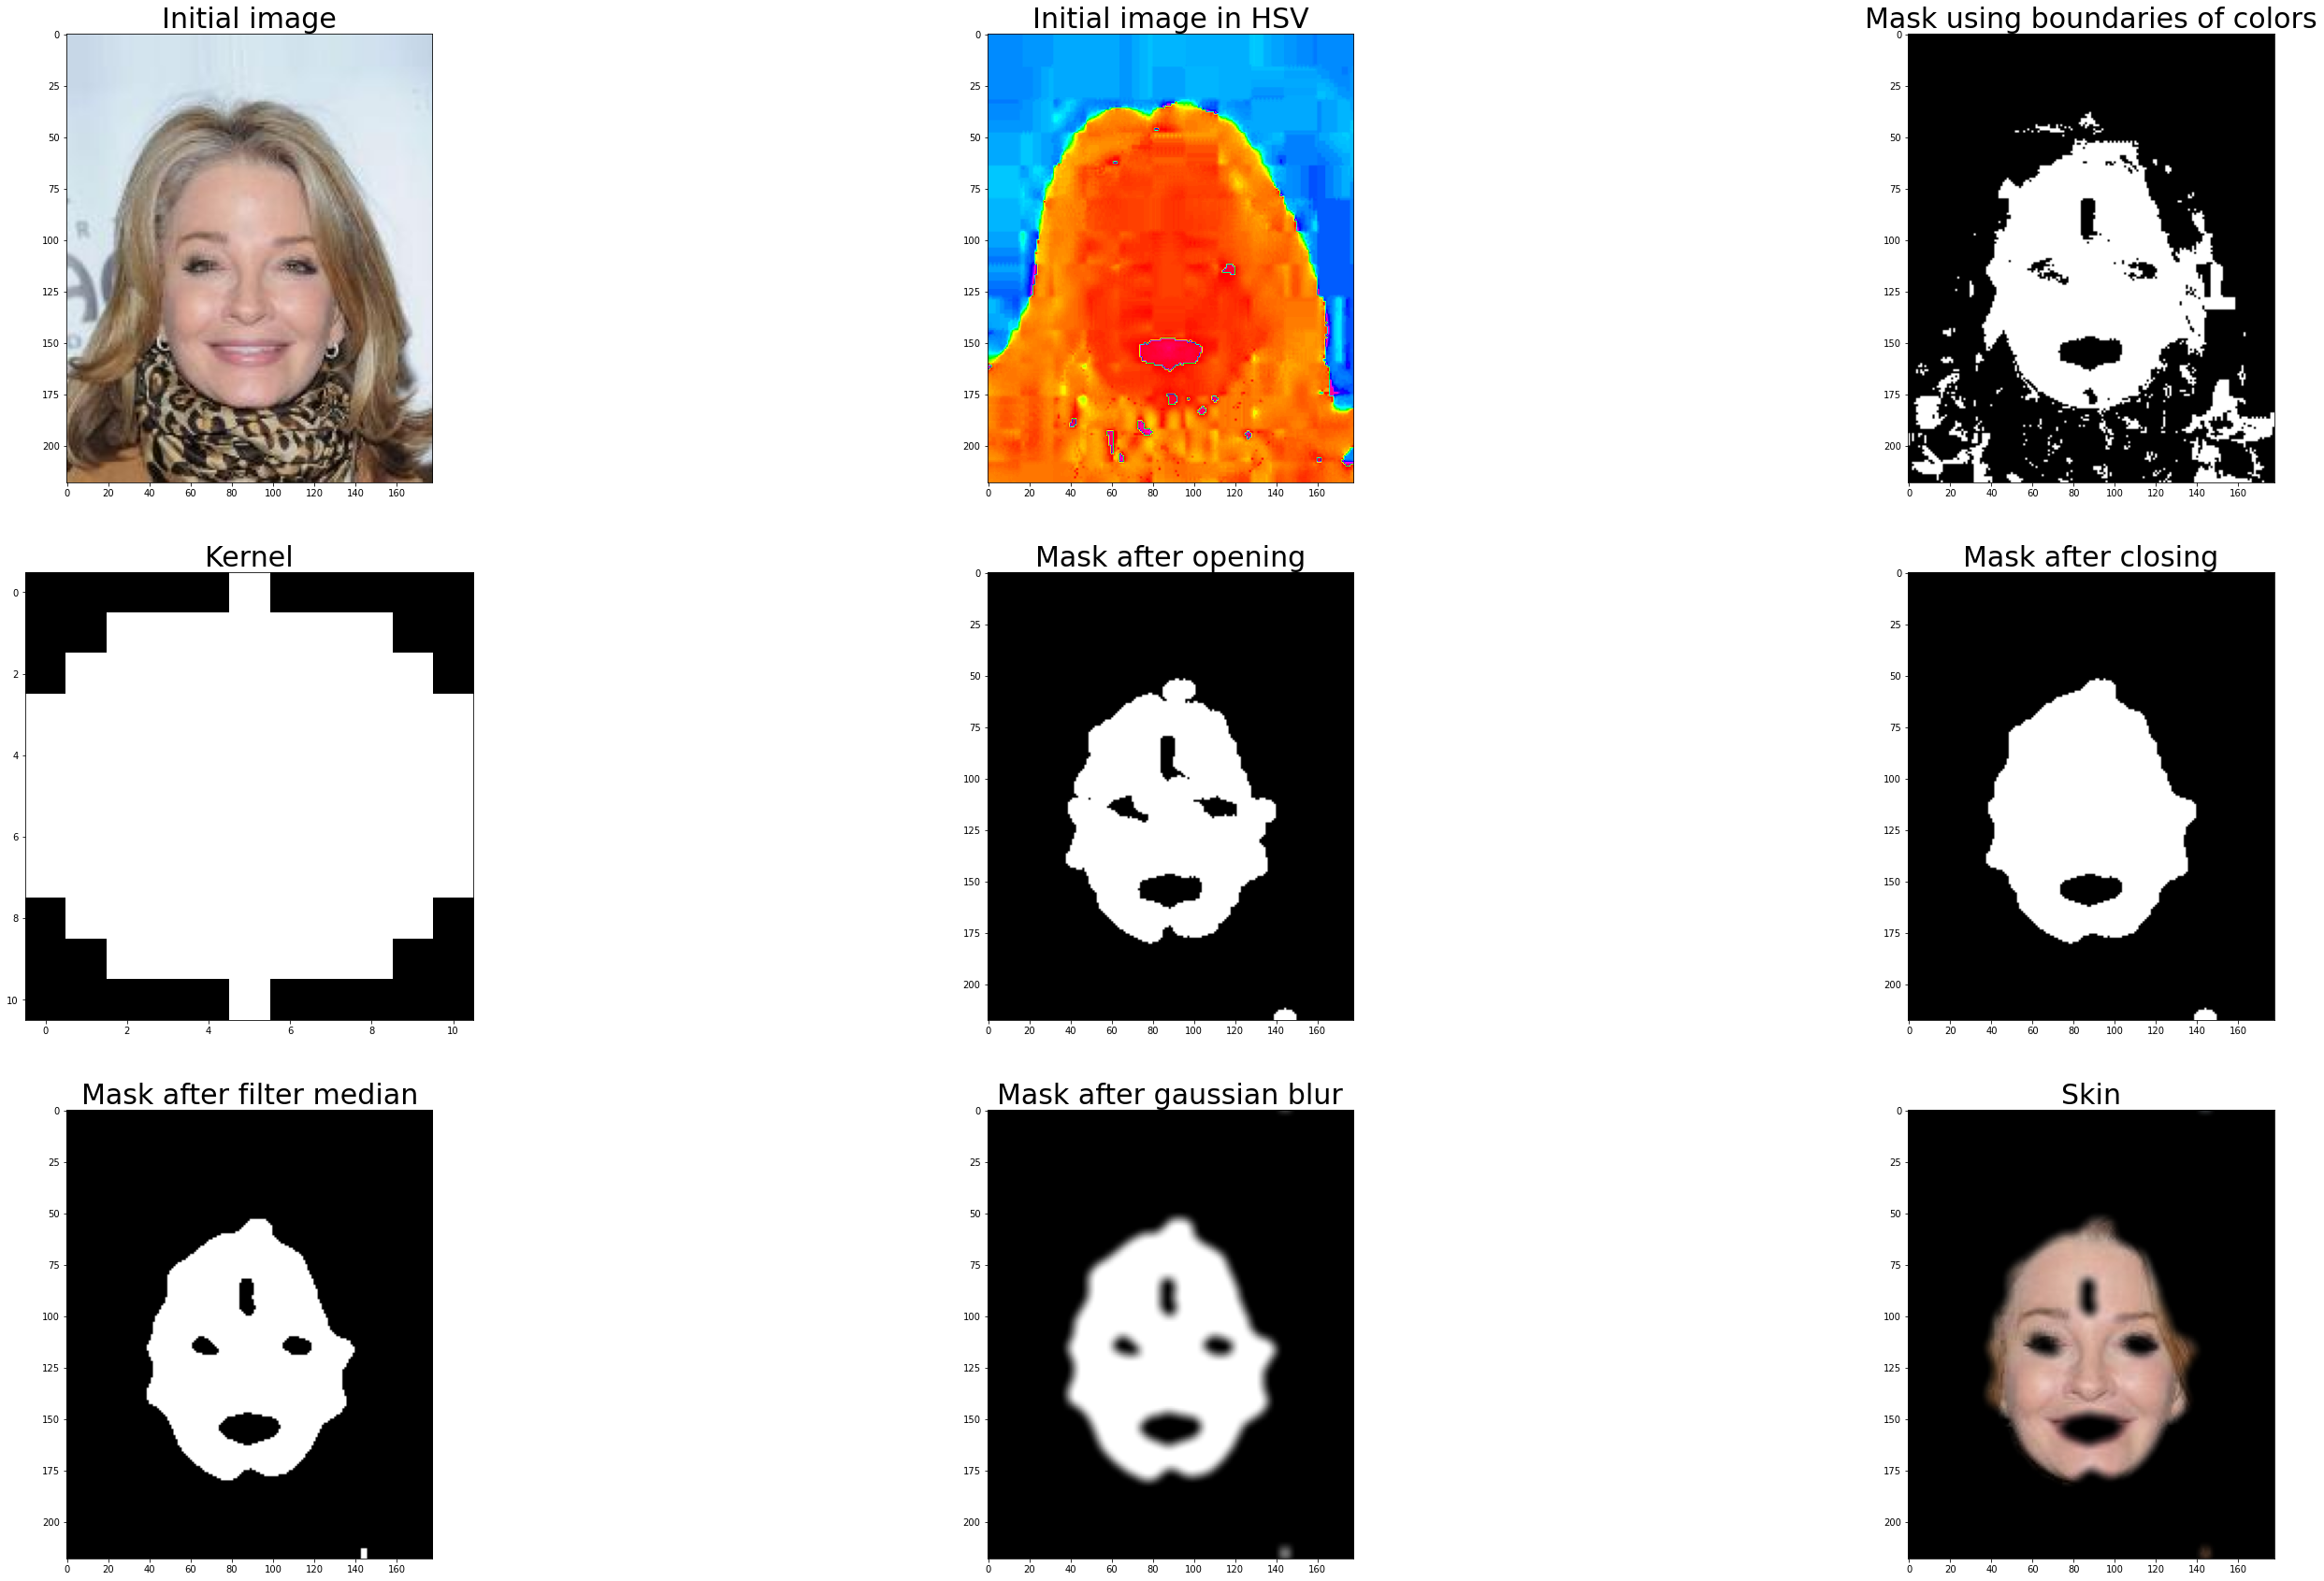

In [36]:
def skin_detection(image_value = 5):
    plt.subplots(figsize=(50,30))
    fontsize = 30
    
    images, df = read_celeba()
    input_filename = "data_faces/img_align_celeba/" + images[image_value]
    input_image = io.imread(input_filename)
    plt.subplot(3, 3, 1); plt.imshow(input_image); plt.title('Initial image', fontdict={'fontsize': fontsize})
    
    hsv_image = rgb2hsv(input_image)
    plt.subplot(3, 3, 2); plt.imshow(hsv_image[:, :,0], cmap="hsv"); plt.title("Initial image in HSV", fontdict={'fontsize': fontsize})
    
    lower, upper = lower_upper_boundaries()
    mask_image = skin_mask(hsv_image, lower, upper)
    plt.subplot(3, 3, 3); plt.imshow(mask_image, cmap="gray"); plt.title('Mask using boundaries of colors', fontdict={'fontsize': fontsize})
    
    mask_image_opening, mask_image_closing, kernel = opening_closing(mask_image)
    plt.subplot(3, 3, 4); plt.imshow(kernel, cmap="gray"); plt.title("Kernel", fontdict={'fontsize': fontsize})
    plt.subplot(3, 3, 5); plt.imshow(mask_image_opening, cmap="gray"); plt.title("Mask after opening", fontdict={'fontsize': fontsize})
    plt.subplot(3, 3, 6); plt.imshow(mask_image_closing, cmap="gray"); plt.title("Mask after closing", fontdict={'fontsize': fontsize})
    
    filtered_mask_image = filter_median(mask_image_opening, 9)
    plt.subplot(3, 3, 7); plt.imshow(filtered_mask_image, cmap="gray"); plt.title("Mask after filter median", fontdict={'fontsize': fontsize})
    
    blurred_mask = gaussian_blur(filtered_mask_image)
    plt.subplot(3, 3, 8); plt.imshow(blurred_mask, cmap="gray"); plt.title("Mask after gaussian blur", fontdict={'fontsize': fontsize})
    
    skin = mask_to_image(blurred_mask, input_image)
    plt.subplot(3, 3, 9); plt.imshow(skin, cmap="gray"); plt.title("Skin", fontdict={'fontsize': fontsize})

    return skin

skin = skin_detection()